# Modeling and Simulation in Python

Chapter 20

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Dropping pennies

I'll start by getting the units we'll need from Pint.

In [6]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

<Unit('kilogram')>

And defining the initial state.

In [7]:
init = State(y=381 * m, 
             v=0 * m/s)

,values
y,381 meter
v,0.0 meter / second


Acceleration due to gravity is about 9.8 m / s$^2$.

In [8]:
g = 9.8 * m/s**2

<Quantity(9.8, 'meter / second ** 2')>

When we call `odeint`, we need an array of timestamps where we want to compute the solution.

I'll start with a duration of 10 seconds.

### With air resistance

Next we'll add air resistance using the [drag equation](https://en.wikipedia.org/wiki/Drag_equation)

First I'll create a `Params` object to contain the quantities we'll need.

In [9]:
params = Params(height = 381 * m,
                      v_init = 0 * m / s,
                      g = 9.8 * m/s**2,
                      mass = 2.5e-3 * kg,
                      diameter = 19e-3 * m,
                      rho = 1.2 * kg/m**3,
                      v_term = 18 * m / s,
                      t_0 = 0 * s,
                      t_end = 30 * s)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
t_0,0 second
t_end,30 second


Now here's a version of `make_system` that takes a `Params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [10]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params with height, g, mass, diameter, 
               rho, v_term, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(params)
    
    init = State(y=height, v=v_init)
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    
    return System(params, init=init, area=area, C_d=C_d)

Let's make a `System`

In [11]:
system = make_system(params)
system

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
t_0,0 second
t_end,30 second
init,y 381 meter v 0.0 meter / secon...


Here's the slope function, including acceleration due to gravity and drag.

In [12]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

As always, let's test the slope function with the initial conditions.

In [13]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

We can use the same event function as last time.

In [14]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And then run the simulation.

In [15]:
results, details = run_ode_solver(system, slope_func, events=event_func)

A termination event occurred.


First check that the simulation ran long enough for the penny to land.

In [16]:
results

,y,v
0.000000,3.810000e+02,0.000000
0.000102,3.810000e+02,-0.001000
0.001122,3.810000e+02,-0.011000
0.011327,3.809994e+02,-0.110998
0.113367,3.809371e+02,-1.109588
1.133773,3.750650e+02,-9.886284
2.336542,3.593541e+02,-15.381283
3.679032,3.370777e+02,-17.358218
5.021521,3.133656e+02,-17.847263
6.657291,2.840359e+02,-17.971703


Then compute the flight time.

In [17]:
t_sidewalk = get_last_label(results)

22.439075231128985

Setting the duration to the computed flight time, we can check the final conditions.

In [18]:
v_sidewalk = get_last_value(results.v)

-18.011550459195657

Interestingly, the final velocity is not exactly terminal velocity, which suggests that there are some numerical errors.

Here's the plot of position as a function of time.

Saving figure to file figs/chap09-fig02.pdf


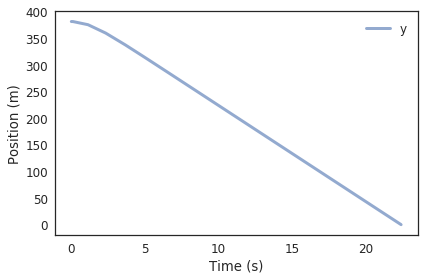

In [19]:
def plot_position(results):
    plot(results.y)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)
savefig('figs/chap09-fig02.pdf')

And velocity as a function of time:

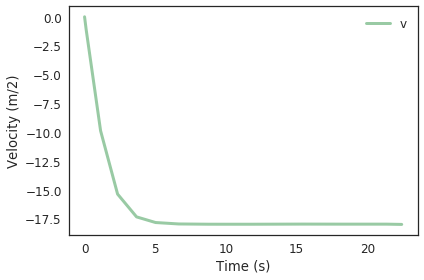

In [20]:
def plot_velocity(results):
    plot(results.v, color='C1', label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/2)')
    
plot_velocity(results)

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

**Exercise:** Run the simulation with an initial velocity, downward, that exceeds the penny's terminal velocity.  Hint: the `Params` object provides a function called `set`.

What do you expect to happen?  Plot velocity and position as a function of time, and see if they are consistent with your prediction.

In [21]:
# Solution

params.set(v_init = -30 * m / s)
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func)

A termination event occurred.


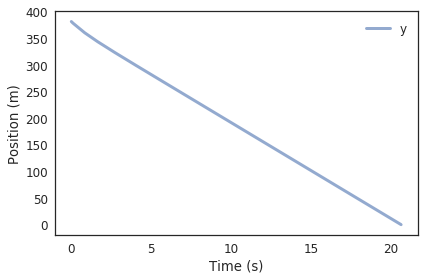

In [22]:
plot_position(results)

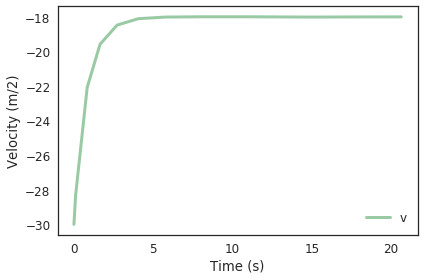

In [23]:
# Solution

plot_velocity(results)

### Dropping quarters

Suppose we drop a quarter from the Empire State Building and find that its flight time is 19.1 seconds.  We can use this measurement to estimate the coefficient of drag.

Here's a `Params` object with the relevant parameters from
https://en.wikipedia.org/wiki/Quarter_(United_States_coin)


In [24]:
params = Params(height = 381 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 5.67e-3 * kg,
                diameter = 24.26e-3 * m,
                rho = 1.2 * kg/m**3,
                t_0 = 0 * s,
                t_end = 19.1 * s)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.00567 kilogram
diameter,0.02426 meter
rho,1.2 kilogram / meter ** 3
t_0,0 second
t_end,19.1 second


And here's a modified version of `make_system`

In [25]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params with height, v_init, g, mass, diameter, 
               rho, C_d, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(params)
    
    init = State(y=height, v=v_init)
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

We can run the simulation with an initial guess of `C_d=0.4`.

In [26]:
params.set(C_d=0.4)
system = make_system(params)
results, details = run_ode_solver(system, slope_func)

The solver successfully reached the interval end.


The final height is -11 meters, which means our guess was too low (we need more drag to slow the quarter down).

In [27]:
get_last_value(results.y)

-11.072723625387098

`height_func` takes a hypothetical value of `C_d` and returns the height after 19.1 seconds.

In [28]:
def height_func(C_d, params):
    """Final height as a function of C_d.
    
    C_d: drag coefficient
    params: Params object
    
    returns: height in m
    """
    params.set(C_d=C_d)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func)
    return get_last_value(results.y)

If we run it with `C_d=0.4`, we get -11 meters again.

In [29]:
height_func(0.4, params)

The solver successfully reached the interval end.


-11.072723625387098

Now we can use `fsolve` to find the value of `C_d` that makes the final height 0.

In [30]:
solution = fsolve(height_func, 0.4, params)

The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.
The solver successfully reached the interval end.


array([0.42595161])

Plugging in the estimated value, we can run the simulation again to get terminal velocity.

In [31]:
params.set(C_d=solution)
system = make_system(params)
results, details = run_ode_solver(system, slope_func)
get_last_value(results.v) * m / s

The solver successfully reached the interval end.


<Quantity(-21.68355627049694, 'meter / second')>

In this example, the terminal velocity of the quarter is higher than that of the penny.  We should not take this result too seriously because the measurements we used are not real; I made them up.

### Exercises